<a href="https://colab.research.google.com/github/hyunlimy/KASP_VitalRecorderWorkshop/blob/main/Code_in_Action_APCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 대한마취약리학회 VitalRecorder workshop 2022
## Code in Action <br> Stroke volume prediction using arterial wave - preprocessing
- Date : Sep. 17, 2022
- Author : **Hyun-Lim Yang, Ph.D.**<br>
Research Assistant Professor @
Seoul National University Hospital <br>
Department of Anesthesiology and Pain Medicine
- E-mail : hlyang{_at_}snu{_dot_}ac{_dot_}kr
***

## 0. Introduction
본 실습에서는 동맥혈압파형을 이용하여 심박출량을 추정할 수 있는 딥러닝 모델을 만드는 것을 목표로 합니다.<br>
실습 코드의 단순화를 위해, gold-standard 로 알려진 thermodilution based cardiac output (TDCO) 을 target으로 맞추지 않고 **arterial pressure based cardiac output 을 맞추는 간단한 실습코드**를 살펴봅니다. <br>
TDCO를 잘 추종할 수 있는 딥러닝 모델을 만들기 위해서는 보다 많은 데이터셋과 복잡한 모델, 오랜 학습시간이 요구됩니다.

***

## 1. Data Preprocessing

### 1-1. Import packages

In [1]:
!pip install vitaldb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
preprocessor_link = '1VAoIAs8Pn9vhMMp4a_KINNJJCIY7pQf8'
model_archi_link = '1qYSCzbns5nM2tqdsU8EtFICMKAfAOXq7'
svpred_aline_link = '1r-2y6_MNvFfbQ4_ZAqj81oOIfIzLM-lV'
svpred_ashw_link = '1Ab7HqOGDMabEEO70nUyHlj8eMf01cB0v'
svpred_chart_link = '1xX1asu7cpj4HK5kXIbznauYTH2c8S_eQ'
svpred_ylabel_link = '12XkmmYZyLpw1SfBw6jCco_rCLf4l4hJo'

In [4]:
!gdown 1VAoIAs8Pn9vhMMp4a_KINNJJCIY7pQf8
!gdown 1qYSCzbns5nM2tqdsU8EtFICMKAfAOXq7
!gdown 1r-2y6_MNvFfbQ4_ZAqj81oOIfIzLM-lV
!gdown 1Ab7HqOGDMabEEO70nUyHlj8eMf01cB0v
!gdown 1xX1asu7cpj4HK5kXIbznauYTH2c8S_eQ
!gdown 12XkmmYZyLpw1SfBw6jCco_rCLf4l4hJo

Downloading...
From: https://drive.google.com/uc?id=1VAoIAs8Pn9vhMMp4a_KINNJJCIY7pQf8
To: /content/kohi_preprocessor.py
100% 27.0k/27.0k [00:00<00:00, 37.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qYSCzbns5nM2tqdsU8EtFICMKAfAOXq7
To: /content/kohi_CNN_model_archi.png
100% 191k/191k [00:00<00:00, 78.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1r-2y6_MNvFfbQ4_ZAqj81oOIfIzLM-lV
To: /content/svpred_alines_20sec.np
100% 1.77G/1.77G [00:12<00:00, 143MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ab7HqOGDMabEEO70nUyHlj8eMf01cB0v
To: /content/svpred_ashw_20sec.np
100% 3.54M/3.54M [00:00<00:00, 109MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xX1asu7cpj4HK5kXIbznauYTH2c8S_eQ
To: /content/svpred_charts_20sec.np
100% 2.21M/2.21M [00:00<00:00, 143MB/s]
Downloading...
From: https://drive.google.com/uc?id=12XkmmYZyLpw1SfBw6jCco_rCLf4l4hJo
To: /content/svpred_ylabels_20sec.np
100% 885k/885k [00:00<00:00, 159MB/s]


In [5]:
import os
cloud_directory = '/content/'
os.listdir(cloud_directory) 

['.config',
 '.ipynb_checkpoints',
 'kohi_CNN_model_archi.png',
 'kohi_preprocessor.py',
 'svpred_ashw_20sec.np',
 'svpred_charts_20sec.np',
 'svpred_alines_20sec.np',
 '__pycache__',
 'svpred_ylabels_20sec.np',
 'sample_data']

In [6]:
import sys

sys.path.append(cloud_directory) 

In [7]:
import os
import sys
download_directory = os.getcwd() 
sys.path.append(download_directory) 

In [8]:
import numpy as np
import pandas as pd
import glob
import kohi_preprocessor as pre
import vitaldb
from tqdm import tqdm
import warnings
warnings.filterwarnings(action='ignore')

download_directory = cloud_directory 

### 1-2. Data loading
샘플 파일을 vitaldb 서버로 부터 직접 다운받아 로드

> **TODO:** `00019.vital`을 100hz로 변환하여 `chart_pd_01`에 DataFrame으로 저장하기

In [9]:
track_names = ["EV1000/SV", "SNUADC/ART"]
### =========== Your code here ====================

vitalfile = vitaldb.VitalFile(19, track_names=track_names)
chart_pd_01 = vitalfile.to_pandas(track_names, interval=1/100)

### ===============================================

print(chart_pd_01.columns)

Index(['EV1000/SV', 'SNUADC/ART'], dtype='object')


In [10]:
col_svs = 'EV1000/SV'
col_art = 'SNUADC/ART'

### 1-3. Stroke volume 데이터 추출

In [11]:
# stroke volume 데이터 추출
### =========== Your code here ====================

svs_data_pd = chart_pd_01[col_svs][chart_pd_01[col_svs].notnull()]
svs_index = svs_data_pd.index.values

### ===============================================
print(svs_data_pd.head())

53845    61.0
54008    61.0
54208    61.0
54408    61.0
54607    61.0
Name: EV1000/SV, dtype: float32


### 1-4. arterial wave 데이터 추출 및 nan 지우기

In [12]:
# art 데이터 전체 추출 및 nan value 채우기
### =========== Your code here ====================

art_full_pd = chart_pd_01[col_art]
art_full_pd = art_full_pd.fillna(0)

### ===============================================

print(art_full_pd.head())

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: SNUADC/ART, dtype: float32


### 1-5. 데이터셋 만들기
필요한 파라미터들 정의

In [13]:
# 필요한 파라미터들 정의
srate = 100
length = 20
max_limit_svs = 200 # svs max : 200
min_limit_svs = 20  # svs min : 20

입력 데이터 길이가 20s이니, svs가 20s 이내에 등장하는 것은 무시함

In [14]:
# svs index를 20초 뒤로 미룸
### =========== Your code here ====================

svs_points = svs_index[svs_index > length*srate]

### ===============================================

print(svs_points)

[  53845   54008   54208 ... 2700200 2700400 2700600]


### 1-6. Arterial wave segment 추출

In [15]:
# arterial segment 추출하기
### =========== Your code here ====================
svs_values_list = [svs_data_pd[idx] for idx in svs_points]
art_seg_list = [art_full_pd[idx-(length*srate):idx].values for idx in svs_points]

### ===============================================

svs_values_np = np.array(svs_values_list)
art_seg_np = np.array(art_seg_list)

print(svs_values_np)
print(art_seg_np)

[61. 61. 61. ... 63. 63. 63.]
[[ 62.2872   62.2872   58.3374  ...  62.2872   65.2496   66.2371 ]
 [ 54.3876   56.3625   62.2872  ...  53.4001   51.4252   50.4377 ]
 [ 65.2496   64.2621   63.2747  ...  75.1242   70.1869   67.2245 ]
 ...
 [  6.00217 -13.747    30.6886  ...  -9.79714  -5.84731  19.8266 ]
 [-26.5839   23.7764   10.9395  ...   2.05234 -16.7093   28.7137 ]
 [-24.609    21.8015    4.02726 ...  -3.8724  -10.7846   20.814  ]]


### 1-7. 조건에 따라 filter들 정의

In [16]:
# 필터들 선언
# svs min-max filter

### =========== Your code here ====================

svs_max_filter = svs_values_np < max_limit_svs
svs_min_filter = svs_values_np > min_limit_svs
svs_filter = svs_max_filter & svs_min_filter

### ===============================================


# abp range filter

### =========== Your code here ====================

art_filter_list = []
for seg in art_seg_np:
    filter_value = (np.array(seg) > 25.0).all() and (np.array(seg) < 250.0).all()
    art_filter_list.append(filter_value)
art_filter = np.array(art_filter_list)

### ===============================================


# mstds 필터

### =========== Your code here ====================

mstds_values_list = []
for seg in tqdm(art_seg_np):
    if (np.array(seg) < 0.).any():
        mstds_values_list.append(float(0.))
    else:
        mstd_val, _ = pre.process_beat(seg)
        mstds_values_list.append(mstd_val)
mstds_filter = np.array(mstds_values_list) > 0.

### ===============================================


100%|██████████| 13217/13217 [02:26<00:00, 90.30it/s]


전체 필터 하나로 만들기

In [17]:
### =========== Your code here ====================

all_filters = svs_filter & art_filter & mstds_filter

### ===============================================


### 필터 적용하여 데이터 추출

In [18]:
# 필터 적용해서 추출

### =========== Your code here ====================

svs_filtered = svs_values_np[all_filters]
art_filtered = art_seg_np[all_filters]

### ===============================================

print(svs_filtered.shape)
print(art_filtered.shape)

(12363,)
(12363, 2000)


데이터셋 정의

In [19]:
x_data = art_filtered
y_label = svs_filtered

In [20]:
print(x_data.shape)
print(y_label.shape)

(12363, 2000)
(12363,)


> **Warning!**
> 상기의 코드는 한 환자에 대해서만 데이터를 추출하는 코드입니다.
> 이 작업을 모든 환자에 대해서 반복하여야 합니다.

## 2. Building Dataset

In [21]:
import pickle
import matplotlib.pylab as plt
%matplotlib inline
import matplotlib.cm as cm

### 2-1. Data loading
사전에 구축된 데이터셋 로드

In [22]:
with open('/content/svpred_alines_20sec.np'.format(download_directory), 'rb') as f:
    aline_data = pickle.load(f)
    
with open('/content/svpred_ylabels_20sec.np'.format(download_directory), 'rb') as f:
    ylabel_data = pickle.load(f)
    
with open('/content/svpred_charts_20sec.np'.format(download_directory), 'rb') as f:
    charts_data = pickle.load(f)
    

### 2-2. Train data와 Valid 데이터로 데이터 구분
편의를 위해 여기선 **180번** 차트 이후의 데이터를 모두 testset으로 구분

In [23]:

### =========== Your code here ====================

test_index = (charts_data > '00180')
train_index = ~test_index

aline_train = aline_data[train_index]
ylabel_train = ylabel_data[train_index]
charts_train = charts_data[train_index]

aline_test = aline_data[test_index]
ylabel_test = ylabel_data[test_index]
charts_test = charts_data[test_index]

### ===============================================


### 2-3. Model building에 필요한 패키지 불러오기

In [24]:
import tensorflow as tf
#import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, concatenate, multiply, dot
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Add, ReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

## 3. 딥러닝 모델 학습

### 3-1. CNN 모델 정의
실습에 사용될 CNN 구조

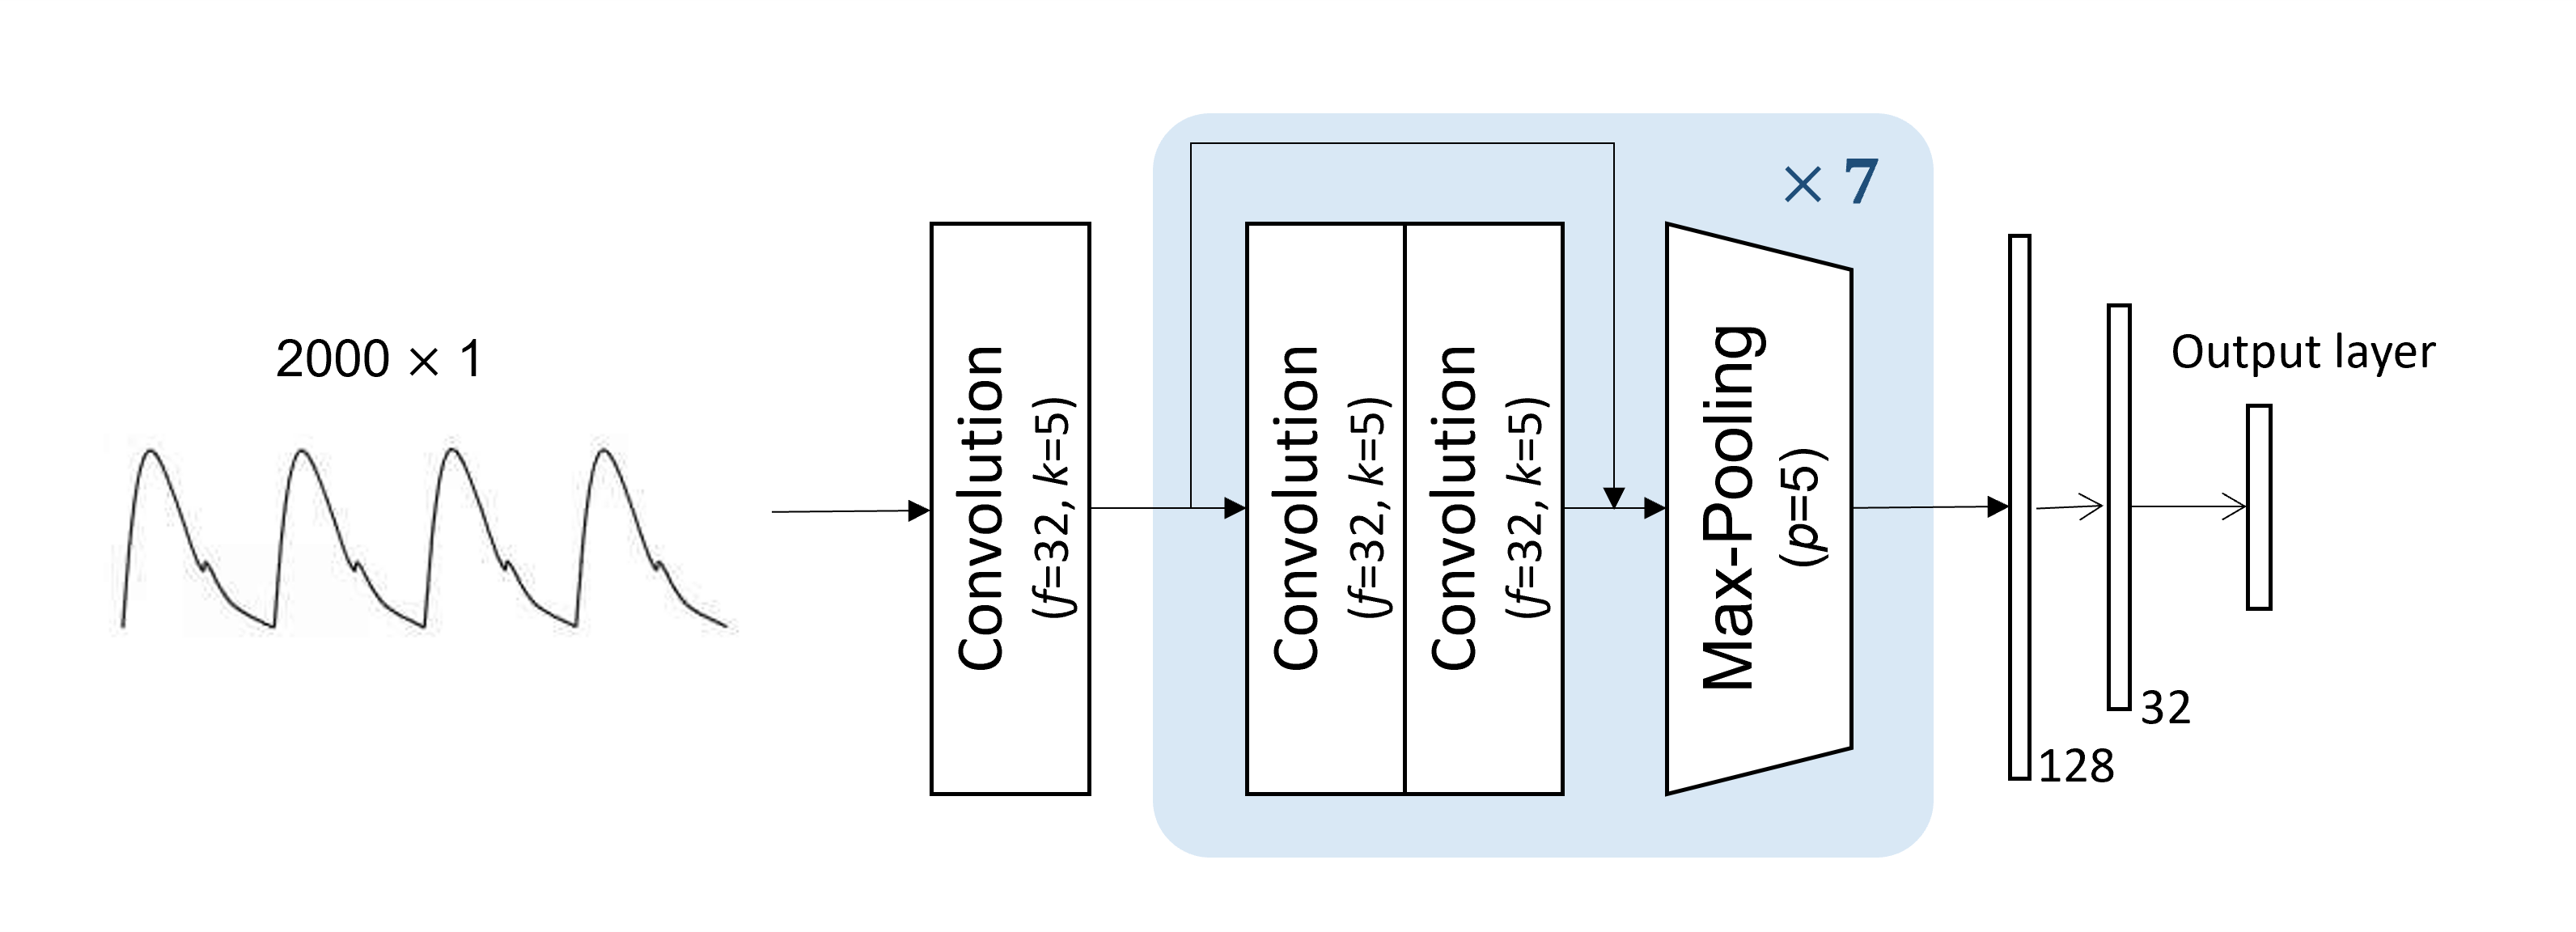

In [25]:
from IPython.display import Image
Image(filename="/content/kohi_CNN_model_archi.png".format(download_directory))

Keras를 이용한 CNN 구현 코드 (Regression problem)

In [26]:
batch_size = 2000

inp = Input(shape=(aline_train.shape[1], 1))

#stem
x = Conv1D(filters=32, kernel_size=5, activation='relu')(inp)

# block 1
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(x)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([x, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 2
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 3
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 4
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 5
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 6
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 7
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# regression을 수행할 수 있는 MLP layer 정의
# Two dense layer with 128 and 32 nodes
### =========== Your code here ====================

# MLP Layers
out = Flatten()(out)
out = Dense(128, activation='relu')(out)
out = Dense(32, activation='relu')(out)
out = Dense(1)(out)

### ===============================================

simple cnn model compile <br>
loss는 `mse` (mean squred error) 를 사용, metric은 `mae` (mean absolute error) 와 `mse` (mean squred error)를 사용 

In [27]:
# 모델의 input과 output pipeline 정의
# 모델 컴파일 
### =========== Your code here ====================

simple_cnn_model = Model(inputs=[inp], outputs=[out])
adam_optimizer = optimizers.Adam(lr=0.0001)
simple_cnn_model.compile(loss='mse', optimizer=adam_optimizer, metrics=['mae', 'mse'])

### ===============================================

In [28]:
simple_cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2000, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1996, 32)     192         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 1996, 32)     5152        ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 1996, 32)     5152        ['conv1d_1[0][0]']               
                                                                                              

### 3-2. 모델 학습 파라미터 정의 및 학습 수행
`cache_path`: 모델이 저장될 경로 지정 <br>
`callback_functions`: 모델 학습에 사용되는 파라미터 설정 <br>

In [29]:
callback_functions = [
                      EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
                      ]

In [30]:
# 모델 학습 수행
### =========== Your code here ====================

simple_cnn_train_history = simple_cnn_model.fit(aline_train, ylabel_train, epochs = 10, 
                                                batch_size=batch_size, verbose=1, validation_split=0.2,
                                               callbacks=callback_functions)

### ===============================================

Epoch 1/10
41/41 [==============================] - 28s 557ms/step - loss: 749.6685 - mae: 21.7481 - mse: 749.6685 - val_loss: 767.6643 - val_mae: 22.7543 - val_mse: 767.6642
Epoch 2/10
41/41 [==============================] - 21s 514ms/step - loss: 580.7807 - mae: 19.3877 - mse: 580.7807 - val_loss: 778.4693 - val_mae: 23.0343 - val_mse: 778.4693
Epoch 3/10
41/41 [==============================] - 21s 519ms/step - loss: 545.2370 - mae: 18.7978 - mse: 545.2370 - val_loss: 673.5823 - val_mae: 21.2729 - val_mse: 673.5823
Epoch 4/10
41/41 [==============================] - 22s 549ms/step - loss: 508.0331 - mae: 18.0927 - mse: 508.0331 - val_loss: 678.7073 - val_mae: 21.3522 - val_mse: 678.7073
Epoch 5/10
41/41 [==============================] - 22s 531ms/step - loss: 476.4845 - mae: 17.3896 - mse: 476.4845 - val_loss: 757.3100 - val_mae: 22.6348 - val_mse: 757.3100
Epoch 6/10
41/41 [==============================] - 22s 529ms/step - loss: 448.9606 - mae: 16.7258 - mse: 448.9606 - val_loss

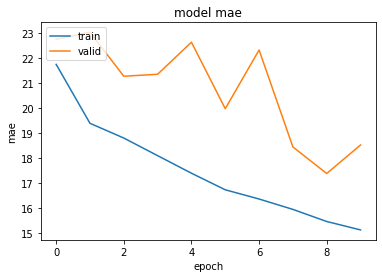

In [31]:
# 모델의 mae loss plotting
### =========== Your code here ====================

plt.plot(simple_cnn_train_history.history['mae'])
plt.plot(simple_cnn_train_history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

### ===============================================

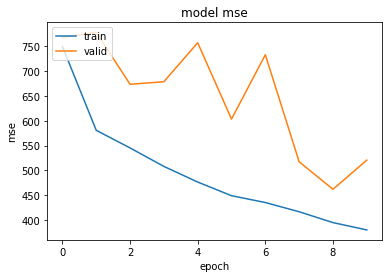

In [32]:
# 모델의 mse loss plotting
### =========== Your code here ====================

plt.plot(simple_cnn_train_history.history['mse'])
plt.plot(simple_cnn_train_history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

### ===============================================

In [33]:
simple_cnn_result = simple_cnn_model.predict(aline_test).flatten()

In [34]:
simple_cnn_result

array([69.18764, 66.85899, 67.64929, ..., 80.35935, 76.55908, 77.84585],
      dtype=float32)

In [35]:
ylabel_test

array([60., 59., 60., ..., 81., 79., 80.])

### 3-3. 학습된 모델 Visialization
> 주황색이 우리 모델의 예측값이고, 파란색의 정답 입니다.

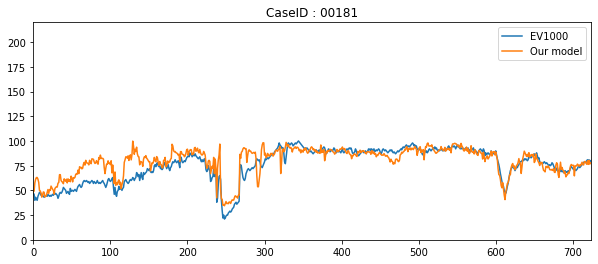

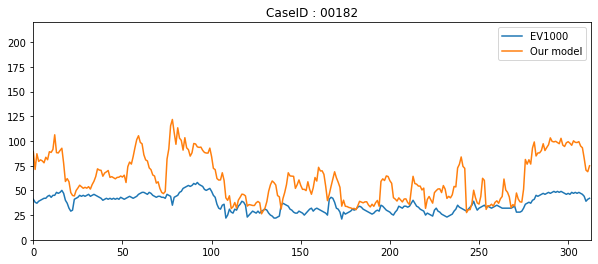

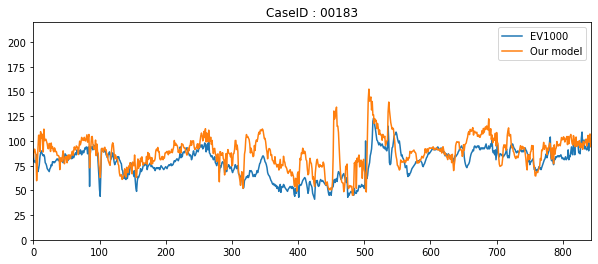

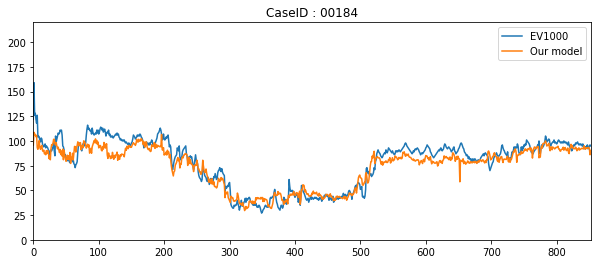

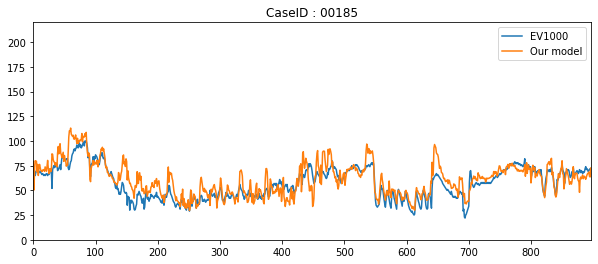

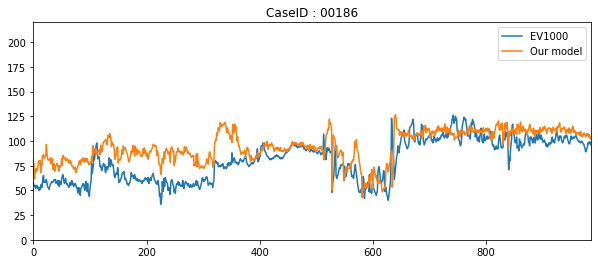

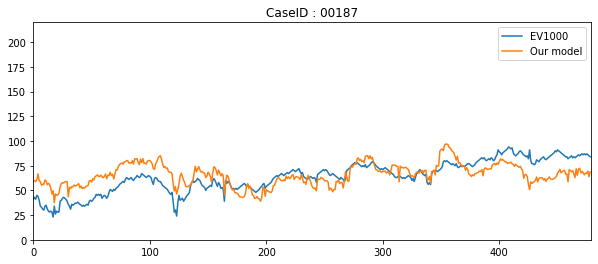

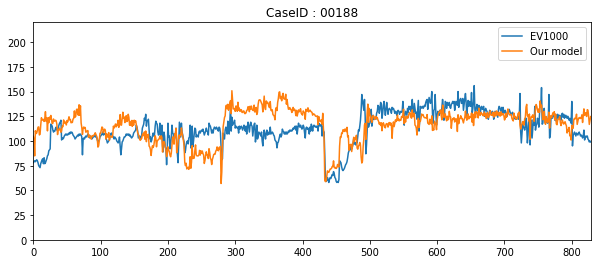

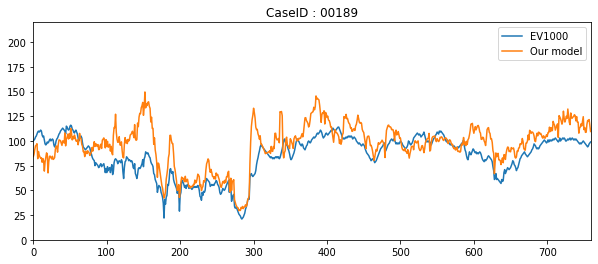

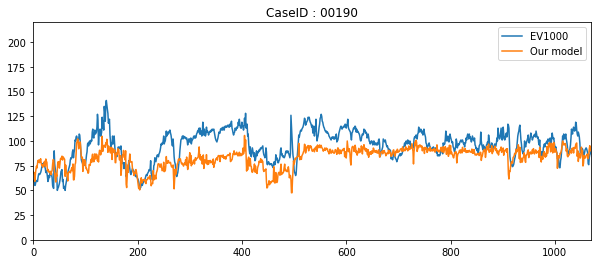

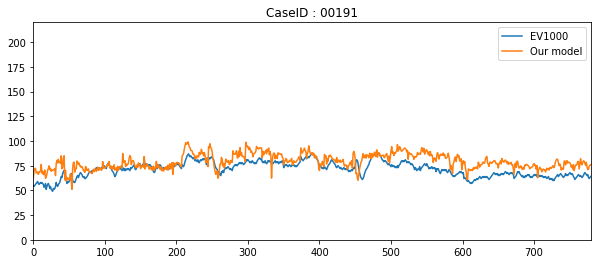

In [36]:
for chart in np.unique(charts_test):
    case_output = simple_cnn_result[charts_test == chart]
    case_target = ylabel_test[charts_test == chart]
    plt.figure(figsize=(10, 4))
    plt.xlim([0, len(case_output)])
    plt.ylim([0, 220])
    plt.plot(np.arange(0, len(case_target)), case_target,
             label='EV1000')
    plt.plot(np.arange(0, len(case_output)), case_output,
             label='Our model')
    plt.legend(loc='upper right')
    # plt.text(0.5, 145, loa_textstr, fontsize=10)
    plt.title('CaseID : {}'.format(chart))
    plt.show()